## Problem Statement: Document Clustering Using Topic Modelling
#### The problem is to develop an automated system that can cluster similar documents together based on their content and uncover hidden topics without relying on predefined labels. This will help users explore, analyze, and understand large collections of documents quickly and effectively.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Importing the Dataset

In [62]:
df = pd.read_csv("Twenty_Newsgroups Dataset.csv")

In [63]:
df.head()

,Text,D_Number,Label,Email,Subject,Processed_text
0,From: mathew <mathew@mantis.co.uk>\nSubject: A...,49960,alt.atheism,mantis netcom mantis,alt atheism atheist resources,atheism resources resources december organizat...
1,From: mathew <mathew@mantis.co.uk>\nSubject: A...,51060,alt.atheism,mantis mantis mantis,alt atheism introduction to atheism,atheism introduction introduction april begin ...
2,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,51119,alt.atheism,dbstu1 edu mimsy umd edu umd,gospel dating,article other words one does not know what the...
3,From: mathew <mathew@mantis.co.uk>\nSubject: R...,51120,alt.atheism,mantis kepler edu unh,university violating separation of church state,recently ras have been ordered mathew
4,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,51121,alt.atheism,Ibm Watson harder ccr harder ccr watson ibm,soc motss et al princeton axes matching funds ...,box yorktown heights


In [64]:
df.sample(5)

,Text,D_Number,Label,Email,Subject,Processed_text
17892,From: Clinton-HQ@Campaign92.Org (The White Hou...,178706,talk.politics.misc,Campaign92 Org,presidential statement on waco,the white house office the press secretary for...
7988,From: ahatcher@athena.cs.uga.edu (Allan Hatche...,104495,rec.motorcycles,edu athena uga msus edu winona stafford MSUS E...,traffic morons,article all standard disclaimers apply
12147,From: Daniel.J.Stern@dartmouth.edu (Daniel J. ...,53920,sci.electronics,edu dartmouth edu Dartmouth,seeking info on wear on monitors,are dartmouth engineering students are looking...
6091,Subject: Looking for a person [VHS for sale]\n...,76156,misc.forsale,hiram edu hiramb,looking for a person vhs for sale,looking for person who made offer for five vhs...
17093,From: mark@fenris.albany.edu (Mark Steinberger...,76481,talk.politics.mideast,edu fenris albany,more on adl spying case,not think and his friends have had much fun fo...


### Text Preprocessing

In [65]:
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\baghe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [66]:
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Remove very large or very short words
    text = re.sub(r'\b\w{1,2}\b|\b\w{13,}\b', '', text)
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove specific frequent words
    frequent_words = set(['article', 'email', 'write', 'writes', 'wrote', 'subject', 're'])
    text = ' '.join(word for word in text.split() if word.lower() not in frequent_words)
    
    return text

In [67]:
df.shape # Shape of Dataset

(18828, 6)

In [68]:
df.isnull().sum()  # Null Values in Dataset

Text                0
D_Number            0
Label               0
Email              64
Subject             1
Processed_text    100
dtype: int64

In [69]:
df.dropna(inplace=True)  # Drop Null Values Because there is less Number of Null Values

In [70]:
df.isnull().sum()

Text              0
D_Number          0
Label             0
Email             0
Subject           0
Processed_text    0
dtype: int64

In [71]:
df.shape

(18664, 6)

In [72]:
df["Label"].value_counts() # Count of Labels in dataset

Label
rec.sport.hockey            992
rec.motorcycles             991
rec.sport.baseball          988
sci.crypt                   988
sci.space                   982
rec.autos                   981
soc.religion.christian      979
sci.med                     976
comp.windows.x              973
sci.electronics             971
comp.os.ms-windows.misc     969
comp.graphics               967
comp.sys.ibm.pc.hardware    966
misc.forsale                957
comp.sys.mac.hardware       950
talk.politics.mideast       938
talk.politics.guns          903
alt.atheism                 795
talk.politics.misc          774
talk.religion.misc          624
Name: count, dtype: int64

### Visualization of Labels count in Percentage

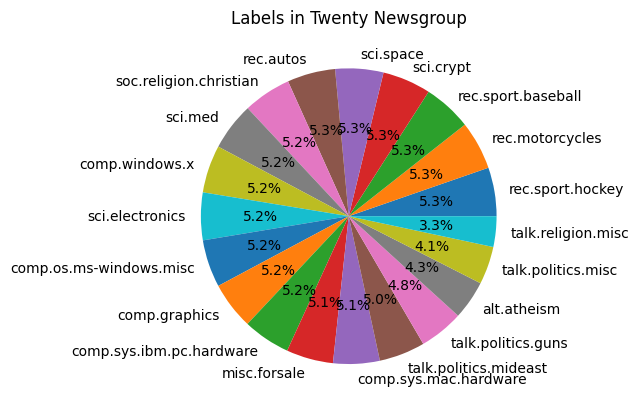

In [73]:
plt.pie(df["Label"].value_counts(),labels=df["Label"].value_counts().index,autopct='%1.1f%%')
plt.title("Labels in Twenty Newsgroup")
plt.savefig(r"static\Labels in dataset.png",transparent=True)
plt.show()

In [74]:
df.info() # Information About the Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 18664 entries, 0 to 18827
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Text            18664 non-null  object
 1   D_Number        18664 non-null  int64 
 2   Label           18664 non-null  object
 3   Email           18664 non-null  object
 4   Subject         18664 non-null  object
 5   Processed_text  18664 non-null  object
dtypes: int64(1), object(5)
memory usage: 1020.7+ KB


In [75]:
y = df["Label"]

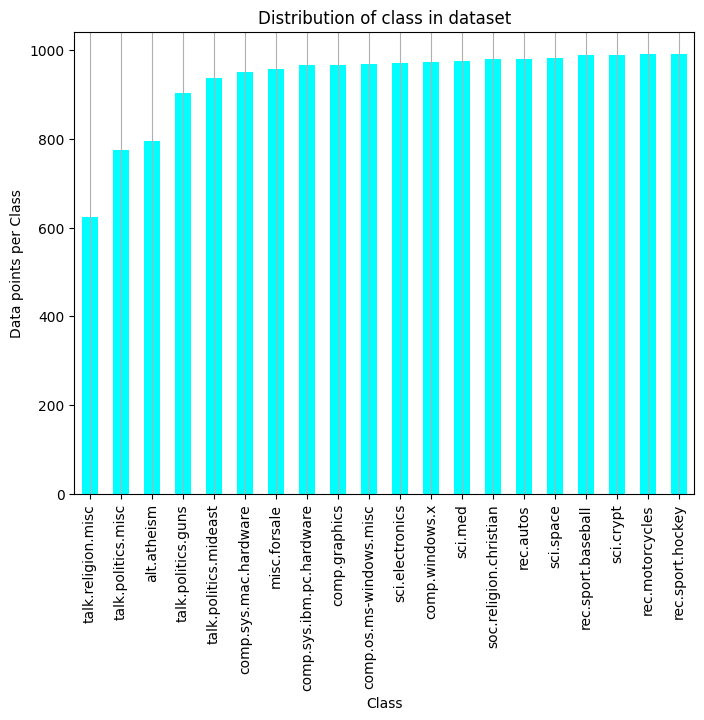

In [76]:
class_distribution = y.value_counts().sort_values()
plt.figure(figsize=(8, 6))
class_distribution.plot(kind = "bar", color = "cyan")

plt.xlabel("Class")
plt.ylabel("Data points per Class")
plt.title("Distribution of class in dataset")
plt.grid(axis='x')
plt.savefig(r"static\labels.png",transparent=True)
plt.show()

In [77]:
df.Processed_text[0]

'atheism resources resources december organizations usa freedom from religion foundation darwin fish bumper stickers and assorted other atheist paraphernalia are available from the freedom from religion foundation the volume contains comprehensive review the principal arguments for and against the existence god ranges from the classical philosophical positions through the moral arguments newman kant and the recent restatements the classical theses and also addresses those positions which push the concept god beyond the realm the rational such those kierkegaard kung and well replacements for god such axiarchism the book delight read less formalistic and better written than works and refreshingly direct when compared with the hand waving james haught illustrated history religious murder and madness looks religious persecution from ancient times the present day and not only congress catalog card number norm allen the listing for african americans for humanism above gordon stein atheism an

In [78]:
texts = df['Processed_text'].fillna('')

In [79]:
texts[0]

'atheism resources resources december organizations usa freedom from religion foundation darwin fish bumper stickers and assorted other atheist paraphernalia are available from the freedom from religion foundation the volume contains comprehensive review the principal arguments for and against the existence god ranges from the classical philosophical positions through the moral arguments newman kant and the recent restatements the classical theses and also addresses those positions which push the concept god beyond the realm the rational such those kierkegaard kung and well replacements for god such axiarchism the book delight read less formalistic and better written than works and refreshingly direct when compared with the hand waving james haught illustrated history religious murder and madness looks religious persecution from ancient times the present day and not only congress catalog card number norm allen the listing for african americans for humanism above gordon stein atheism an

In [80]:
text_data = " ".join(df['Processed_text'])

In [81]:
from wordcloud import WordCloud

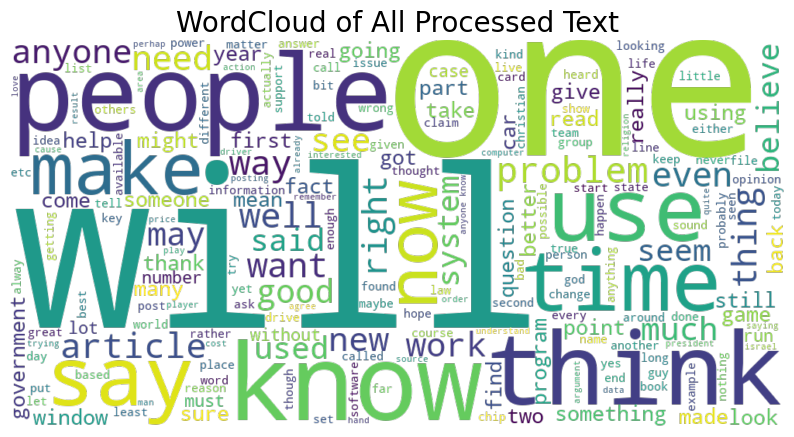

In [82]:
wordcloud = WordCloud(width=1000, height=500, background_color=None,mode='RGBA', colormap='viridis').generate(text_data)

# Plot
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of All Processed Text", fontsize=20)
plt.savefig(r"static\wordcloud.png",transparent=True)
plt.show()

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [84]:
vectorizer = TfidfVectorizer(lowercase=True,max_features=1000,
                      #selecting top 200 features by term frequency
                             max_df=0.7, # Ignore terms that appear in more than 70% of the documents
                             min_df=4,  # Ignore terms that appear in fewer than 4 documents
 # Consider unigrams, bigrams, and trigrams
                             stop_words = "english")
X = vectorizer.fit_transform(texts)

In [85]:
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,ability,able,absolutely,accept,access,according,account,act,action,actions,...,written,wrong,wrote,yeah,year,years,yes,yesterday,york,young
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.104119,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.011269,0.0,0.0,0.0,0.013583,0.0,0.0,0.0,0.030164,...,0.000000,0.022637,0.0,0.0,0.0,0.020519,0.011658,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [86]:
tfidf_df.shape

(18664, 1000)

### Model Building

In [87]:
from sklearn.cluster import KMeans

In [88]:
wcss = []
K = range(2, 21)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)  # X = your TF-IDF matrix
    wcss.append(kmeans.inertia_)  # Within-Cluster Sum of Squares

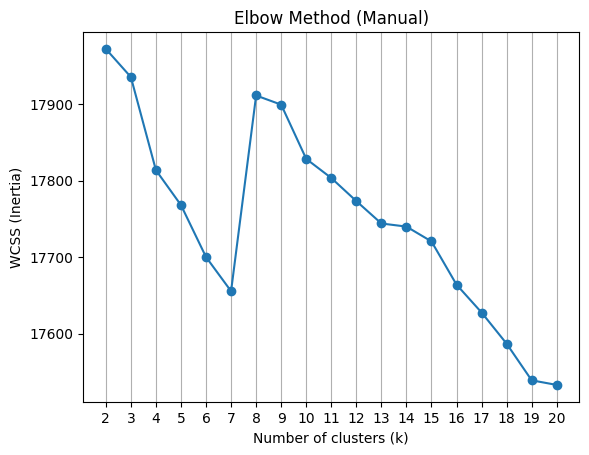

In [89]:
plt.plot(K, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method (Manual)')
plt.grid(axis='x')
plt.xticks(K)
plt.savefig(r"static\Elbow method.png",transparent=True)
plt.show()

In [90]:
kmeans = KMeans(n_clusters=20, random_state=42)  # or any k
kmeans.fit(X)
df['Cluster'] = kmeans.labels_

In [91]:
df.head()

,Text,D_Number,Label,Email,Subject,Processed_text,Cluster
0,From: mathew <mathew@mantis.co.uk>\nSubject: A...,49960,alt.atheism,mantis netcom mantis,alt atheism atheist resources,atheism resources resources december organizat...,18
1,From: mathew <mathew@mantis.co.uk>\nSubject: A...,51060,alt.atheism,mantis mantis mantis,alt atheism introduction to atheism,atheism introduction introduction april begin ...,18
2,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,51119,alt.atheism,dbstu1 edu mimsy umd edu umd,gospel dating,article other words one does not know what the...,6
3,From: mathew <mathew@mantis.co.uk>\nSubject: R...,51120,alt.atheism,mantis kepler edu unh,university violating separation of church state,recently ras have been ordered mathew,6
4,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,51121,alt.atheism,Ibm Watson harder ccr harder ccr watson ibm,soc motss et al princeton axes matching funds ...,box yorktown heights,6


### Testing of Model Using Giving Input Text

In [92]:
new_text = "box yorktown heights"

In [93]:
new_text_vector = vectorizer.transform([new_text])

In [94]:
predicted_cluster = kmeans.predict(new_text_vector)
print("Predicted Cluster:", predicted_cluster[0])

Predicted Cluster: 6


In [95]:
from sklearn.metrics import silhouette_score
cluster_labels = kmeans.labels_
score = silhouette_score(X, cluster_labels)

print(f"Silhouette Score: {score:.4f}")

Silhouette Score: -0.0098


In [96]:
cluster_to_category = df.groupby('Cluster')['Label'].agg(lambda x: x.mode()[0]).to_dict()

In [97]:
cluster_to_category

{0: 'rec.autos',
 1: 'comp.sys.ibm.pc.hardware',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.windows.x',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'talk.politics.mideast',
 7: 'sci.crypt',
 8: 'rec.sport.hockey',
 9: 'rec.sport.baseball',
 10: 'comp.windows.x',
 11: 'comp.os.ms-windows.misc',
 12: 'rec.sport.hockey',
 13: 'talk.politics.misc',
 14: 'talk.politics.misc',
 15: 'comp.sys.ibm.pc.hardware',
 16: 'rec.autos',
 17: 'rec.sport.hockey',
 18: 'soc.religion.christian',
 19: 'sci.space'}

In [98]:
predicted_category = cluster_to_category.get(predicted_cluster[0], "Unknown Category")
predicted_category

'talk.politics.mideast'

### Top Keywords in Cluster

In [99]:
def get_top_keywords(kmeans, vectorizer, cluster_id, n_terms=10):
    centroids = kmeans.cluster_centers_
    terms = vectorizer.get_feature_names_out()
    top_indices = centroids[cluster_id].argsort()[::-1][:n_terms]
    return [terms[i] for i in top_indices]

top_words = get_top_keywords(kmeans, vectorizer, predicted_cluster[0])
print("Top keywords in this cluster:", top_words)

Top keywords in this cluster: ['article', 'people', 'just', 'like', 'think', 'did', 'does', 'time', 'know', 'right']


In [100]:
words = ""
for word in top_words:
    words = words+" "+word
print(words)

 article people just like think did does time know right


### Visualisation of Top Keywords in Cluster

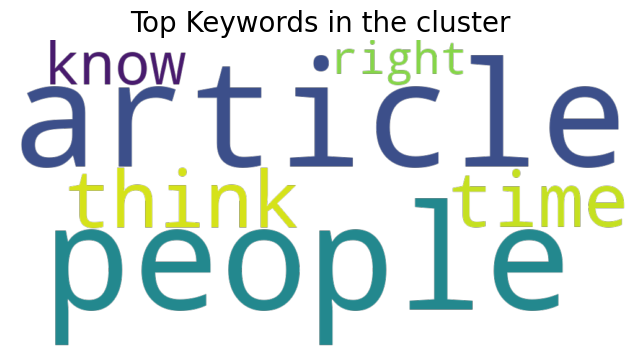

In [101]:
# Generate WordCloud
wordcloud = WordCloud(width=1000, height=500, background_color=None,mode='RGBA', colormap='viridis').generate(words)

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Keywords in the cluster", fontsize=20)
plt.show()


### Dimensionality Reduction

In [102]:
from sklearn.decomposition import PCA

In [103]:
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X.toarray())  # Convert sparse matrix to dense

In [104]:
labels = kmeans.labels_

In [105]:
centroids_reduced = pca.transform(kmeans.cluster_centers_)

### Visualization of Clusters with Centroids

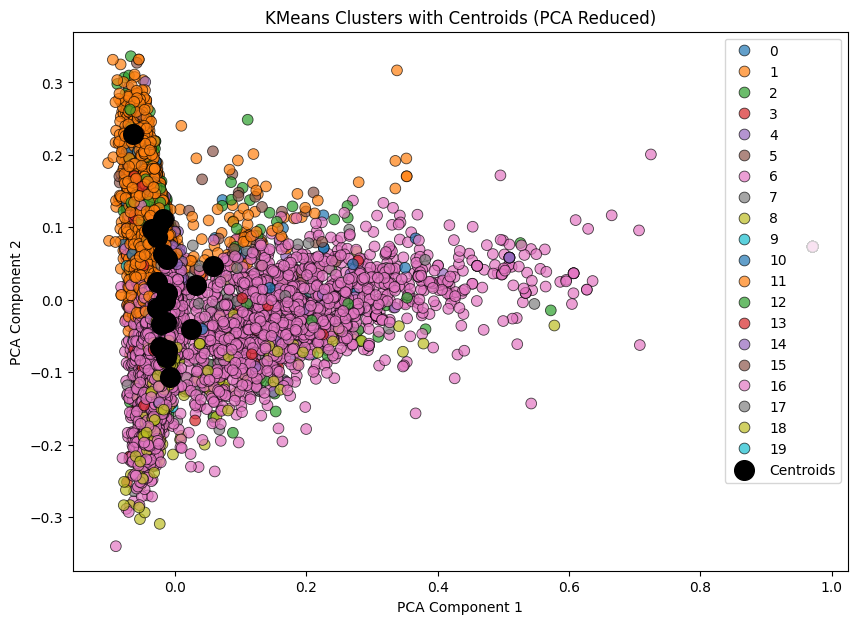

In [106]:
plt.figure(figsize=(10, 7))

# Plot the documents
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels, palette='tab10', s=60, alpha=0.7, edgecolor='k')

# Plot the centroids
plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], 
            s=200, c='black', marker='o', label='Centroids')

plt.title("KMeans Clusters with Centroids (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.savefig(r"static\cluster_graph.png",transparent=True)
plt.show()

### Save the Models

In [107]:
import joblib
joblib.dump(kmeans,open("KMeans-clustering.pkl",'wb'))
joblib.dump(vectorizer,open("Vectorizer.pkl",'wb'))